In [1]:
%env WANDB_SILENT=True
%env "WANDB_NOTEBOOK_NAME" "del_mc1"

import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torcheval.metrics import MulticlassAccuracy
from config import default_config
import torch.optim as optim
import numpy as np

import wandb

#### Downloading Datasets

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

def normalize_img(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

Files already downloaded and verified
Files already downloaded and verified


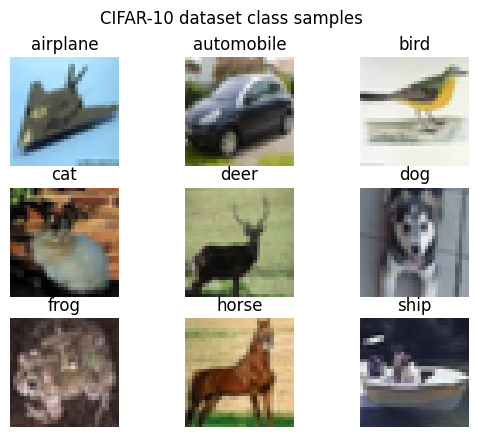

In [3]:
fig, axs = plt.subplots(3, 3)
fig.suptitle('CIFAR-10 dataset class samples')

independent_class_images = dict()

while len(independent_class_images) != 10:
    index = np.random.randint(0, len(cifar_trainset))
    image = cifar_trainset[index]
    independent_class_images[image[1]] = image[0]

for i in range(3):
    for j in range(3):
        axs[i, j].imshow(normalize_img(independent_class_images[i*3+j]))
        axs[i, j].set_title(cifar_trainset.classes[i*3+j])
        axs[i, j].axis('off')

plt.show()

In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


## Base Functions

In [5]:
def train(model: nn.Module, 
          optimizer, 
          criterion, 
          data_loader: torch.utils.data.DataLoader, 
          device,
          n_classes: int,
          verbose=True, verbose_interval=2000,
          current_epoch: int =1):
    acc = MulticlassAccuracy(num_classes=n_classes, device=device)

    running_loss = 0.0
    verbose_loss = 0.0

    for i, data in enumerate(data_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        acc.update(outputs, labels)
        running_loss += loss.item()
        verbose_loss += loss.item()
        
        if verbose and i % verbose_interval == verbose_interval - 1:
            print(f'[Epoch {current_epoch}, {i + 1}] loss: {verbose_loss / verbose_interval:.3f}')
            verbose_loss = 0.0
    
    train_loss = running_loss / len(data_loader)

    return {"train_accuracy": acc.compute(), "train_loss": train_loss}

In [6]:
def test(model: nn.Module,
         criterion,
         data_loader: torch.utils.data.DataLoader,
         device,
         n_classes: int
         ):
    accuracy = MulticlassAccuracy(num_classes=n_classes, device=device)
    
    model.eval()
    y_true = []
    y_pred = []
    test_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            data, target = data.view(-1, 3, 32, 32), target
            y_true.append(target)

            output = model(data)
            y_pred.append(output)

            test_loss += criterion(output, target).item()

            class_pred = output.argmax(dim=1)

            accuracy.update(class_pred, target)
    
    test_loss /= len(data_loader.dataset)

    return { "test_accuracy": accuracy.compute(), "test_loss": test_loss}

In [7]:
def assess_model(model: nn.Module, 
                 criterion, 
                 optimizer,
                 train_loader: torch.utils.data.DataLoader,
                 test_loader: torch.utils.data.DataLoader,
                 config=default_config,
                 weight_init: str = 'kaiming',
                 learning_rate: float = 0.01,
                 n_epochs: int = 10,
                 n_classes: int = 10,
                 run_name: str = None,
                 tags: list[str] = None,
                 verbose: bool = False
                ):
    torch.manual_seed(config["seed"])
    np.random.seed(config["seed"])

    if optimizer is None:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    for m in model.modules():
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            if weight_init == 'kaiming':
                torch.nn.init.kaiming_normal_(m.weight)
            elif weight_init == 'xavier':
                torch.nn.init.xavier_normal_(m.weight)
            elif weight_init == 'normal':
                mean = m.weight.mean().item()
                std = m.weight.std().item()
                torch.nn.init.normal_(m.weight, mean, std)
            else:
                raise ValueError(f"Unknown weight initialization method: {weight_init}")

    with wandb.init(project="del-mc1", 
                    name=run_name if run_name is not None else model.__class__.__name__, 
                    config=default_config,
                    tags=tags if tags is not None else None,
                    settings=wandb.Settings(disable_job_creation=True)
                    ) as run:
        use_cuda = torch.cuda.is_available()

        device = torch.device("cuda" if use_cuda else "cpu")
        model.to(device)
        print(f"--- Running Experiment {run_name} ---")
        torch.manual_seed(config["seed"]) 

        for epoch in range(1, n_epochs + 1):
            train_metrics = train(model, optimizer, criterion, train_loader, device, n_classes, current_epoch=epoch, verbose=verbose)
            test_metrics = test(model, criterion, test_loader, device, n_classes)
            wandb.log({**train_metrics, **test_metrics, "epoch": epoch})    
            print(f"Epoch {epoch} - Train accuracy: {train_metrics['train_accuracy']:.3f}, Test accuracy: {test_metrics['test_accuracy']:.3f}")

        print(f"View run at: https://wandb.ai/{run.entity}/{run.project}/{run.id}")
        print()


## Base Model

In [8]:
def BaseCNN():
    return nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Flatten(),
        nn.Linear(4096 , 512),
        nn.ReLU(),
        nn.Linear(512, 10)
        # no softmax here, since we will use cross-entropy as activation and torch will apply it for us
    )

## Overfit Testing

In [9]:
single_sample_subset = torch.utils.data.Subset(cifar_trainset, [0])
single_sample_loader = torch.utils.data.DataLoader(single_sample_subset, batch_size=1, shuffle=False)

train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=64, shuffle=True) 
test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=64, shuffle=False)

assess_model(BaseCNN(), 
             nn.CrossEntropyLoss(),
             None, 
             single_sample_loader, 
             single_sample_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=3,
             n_classes=10,
             run_name="Overfit_Test")

--- Running Experiment Overfit_Test ---
Epoch 1 - Train accuracy: 0.000, Test accuracy: 1.000
Epoch 2 - Train accuracy: 1.000, Test accuracy: 1.000
Epoch 3 - Train accuracy: 1.000, Test accuracy: 1.000
View run at: https://wandb.ai/okaynils/del-mc1/28hnwk23



## Exploring Weight-Initialization

In [10]:
assess_model(model=BaseCNN(),
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=10,
             n_classes=10,
             weight_init='kaiming',
             run_name="Kaiming_Init")

assess_model(model=BaseCNN(),
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=10,
             n_classes=10,
             weight_init='xavier',
             run_name="Xavier_Init")

assess_model(model=BaseCNN(),
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=10,
             n_classes=10,
             weight_init='normal',
             run_name="Normal_Init")

--- Running Experiment Kaiming_Init ---
Epoch 1 - Train accuracy: 0.402, Test accuracy: 0.470
Epoch 2 - Train accuracy: 0.506, Test accuracy: 0.508
Epoch 3 - Train accuracy: 0.551, Test accuracy: 0.541
Epoch 4 - Train accuracy: 0.582, Test accuracy: 0.559
Epoch 5 - Train accuracy: 0.609, Test accuracy: 0.577
Epoch 6 - Train accuracy: 0.631, Test accuracy: 0.574
Epoch 7 - Train accuracy: 0.651, Test accuracy: 0.573
Epoch 8 - Train accuracy: 0.668, Test accuracy: 0.604
Epoch 9 - Train accuracy: 0.684, Test accuracy: 0.569
Epoch 10 - Train accuracy: 0.701, Test accuracy: 0.620
View run at: https://wandb.ai/okaynils/del-mc1/dioqzmin

--- Running Experiment Xavier_Init ---
Epoch 1 - Train accuracy: 0.370, Test accuracy: 0.439
Epoch 2 - Train accuracy: 0.470, Test accuracy: 0.466
Epoch 3 - Train accuracy: 0.519, Test accuracy: 0.517
Epoch 4 - Train accuracy: 0.555, Test accuracy: 0.541
Epoch 5 - Train accuracy: 0.585, Test accuracy: 0.569
Epoch 6 - Train accuracy: 0.608, Test accuracy: 0.565

### Conclusion on Weight Initialization

In [11]:
%wandb okaynils/del-mc1/lxu0b17s